# Face Recognition Using Eigenfaces

## Paper

1. Read dataset, calculate the mean face

2. Calculate covariance matrix

3. Select top k eigenvalues and eigenvectors

4. Calculate Euclidean distance

5. Classification, metrics, confusion matrix (Recall, Precision)

6. Reconstruct eigenfaces for visualization

7. Determine a new image has face or not, threshold

8. Determine a new image is known or unknown, threshold

8. Recognize test images from internet


## (Optional) Real-time recogntion

1. Detection: Open-CV

2. Recogntion improvement: LDA

In [1]:
import sys
sys.path.append('../src')

from utils import *
from pca import *

In [2]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

In [3]:
# Only use people with more than 70 images, default resize=0.5
lfw_people = fetch_lfw_people(data_home="../data", min_faces_per_person=70, resize=1)
n_samples, h, w = lfw_people.images.shape

# Use the 1-D pixels as features, positions info is ignored
X = lfw_people.data
n_features = X.shape[1]

# The label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("#Samples:", n_samples)
print("#Features Dimention:", n_features)
print("#Classes:", n_classes)

# X: (N x d), N: number of samples, d: feature dimention
print("X shape (N, d):", X.shape)
print(f"Image h, w: {h}, {w}")

#Samples: 1288
#Features Dimention: 11750
#Classes: 7
X shape (N, d): (1288, 11750)
Image h, w: 125, 94


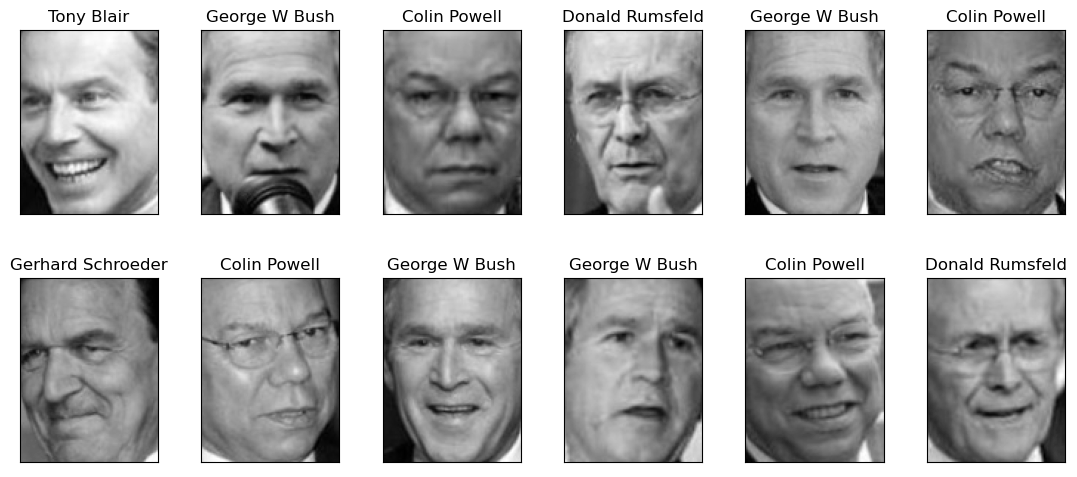

In [4]:
np.random.seed(0)
idx = np.random.randint(0, n_samples, 12)
images = lfw_people.images[idx]
plot_gallery(images, target_names[y[idx]], n_row=2, n_col=6)

Mean face shape: (11750,)


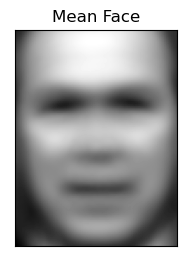

In [5]:
mean = mean_face(X)
print("Mean face shape:", mean.shape)
plot_gallery([mean.reshape(h, w)], ["Mean Face"], n_row=1, n_col=1)

In [6]:
# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)
mean = mean_face(X)

cov = cov_matrix(X, mean)
is_symmetric = np.allclose(cov, cov.T)
print("Covariance matrix is symmetric", is_symmetric)
print("Covariance matrix shape:", cov.shape)
print(cov[0][:20])

Covariance matrix is symmetric True
Covariance matrix shape: (1288, 1288)
[ 5.5100760e+00 -7.7027625e-01  2.2901322e-01  5.0200492e-02
 -2.6315922e-01 -1.9277444e+00 -4.6875706e-01  1.9554649e-01
 -1.8894970e+00 -8.6652637e-01 -1.4105459e+00 -2.4648106e+00
  1.1927737e+00 -6.6733450e-02  1.1190951e+00 -5.3100133e-01
  2.0085719e-01  4.6073213e-01  4.8499433e-03  8.5156053e-01]


In [7]:
eigval, eigvec = eigen(X, mean)
print("Eigenvalues shape:", eigval.shape)
print("Eigenvectors shape:", eigvec.shape)

eigface, weights = PCA(X, mean)
print("Eigenfaces shape:", eigface.shape)
print("Weights shape:", weights.shape)

Eigenvalues shape: (1288,)
Eigenvectors shape: (11750, 1288)
Eigenfaces shape: (11750, 150)
Weights shape: (1288, 150)


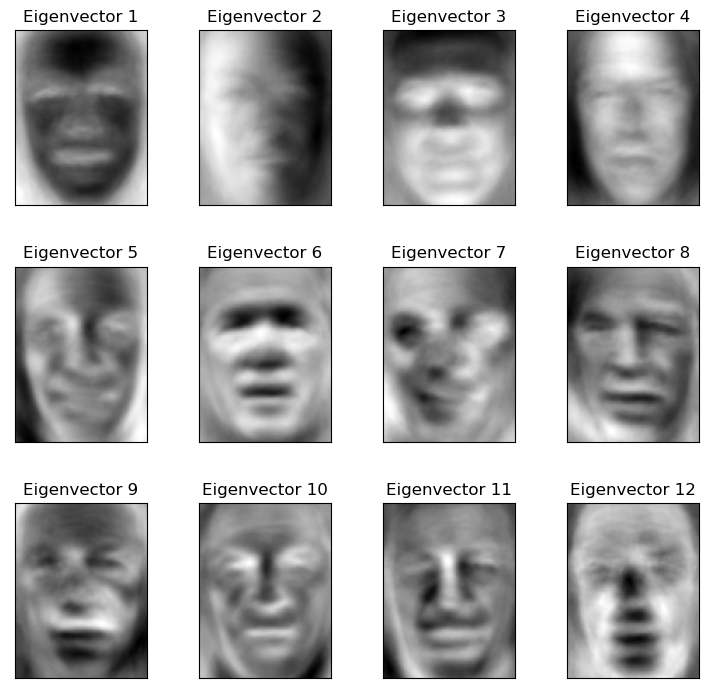

In [8]:
# Visualization of principal components
images = eigface[:, :12].T.reshape(-1, h, w)
plot_gallery(images, ["Eigenvector %d" % i for i in range(1, 13)])

In [9]:
proj = project(X, mean, eigface)
print("Projected shape:", proj.shape)
dist = euclidean(proj, weights)
print("Euclidean distance shape:", dist.shape)

Projected shape: (1288, 150)
Euclidean distance shape: (1288, 1288)


                   precision    recall  f1-score   support

     Ariel Sharon       0.05      0.08      0.06        13
     Colin Powell       0.38      0.38      0.38        60
  Donald Rumsfeld       0.27      0.33      0.30        27
    George W Bush       0.55      0.49      0.52       146
Gerhard Schroeder       0.11      0.12      0.11        25
      Hugo Chavez       0.13      0.20      0.16        15
       Tony Blair       0.21      0.17      0.19        36

         accuracy                           0.36       322
        macro avg       0.24      0.25      0.25       322
     weighted avg       0.38      0.36      0.37       322



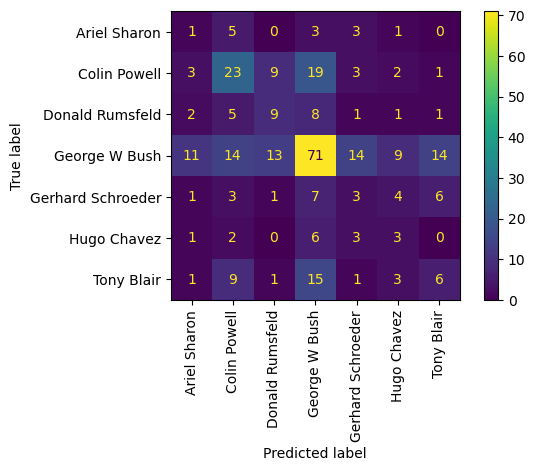

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_pred = pipeline(X_train, X_test, y_train, y_test)

report(y_test, y_pred, target_names)

## SVM Classifier

In [11]:
k = 150
print(f"Extracting the top {k} eigenfaces from {len(X_train)} faces")

mean = mean_face(X_train)
eigface, weights = PCA(X_train, mean, k)

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = weights
X_test_pca = project(X_test, mean, eigface)

print("Train PCA shape:", X_train_pca.shape)
print(X_train_pca[0][:20])

Extracting the top 150 eigenfaces from 966 faces
Projecting the input data on the eigenfaces orthonormal basis
Train PCA shape: (966, 150)
[30.515352   16.293135   -5.828969   10.497506   -0.71114844 -3.44742
  2.1562383  -0.56681746  1.328593   -0.44876626  1.4880618  -2.5003033
  1.5648798  -3.0565274   1.075528   -2.8344133   2.5720427  -0.6945885
 -0.931831   -0.6993234 ]


In [12]:
print("Fitting the classifier to the training set")
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=1386.986124535732, class_weight='balanced', gamma=0.00018255254802399)


Predicting people's names on the test set
                   precision    recall  f1-score   support

     Ariel Sharon       0.50      0.69      0.58        13
     Colin Powell       0.75      0.82      0.78        60
  Donald Rumsfeld       0.48      0.52      0.50        27
    George W Bush       0.84      0.82      0.83       146
Gerhard Schroeder       0.74      0.68      0.71        25
      Hugo Chavez       0.58      0.47      0.52        15
       Tony Blair       0.67      0.61      0.64        36

         accuracy                           0.74       322
        macro avg       0.65      0.66      0.65       322
     weighted avg       0.74      0.74      0.74       322



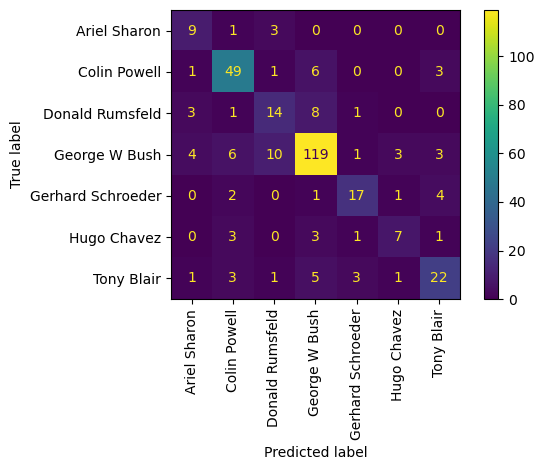

In [13]:
print("Predicting people's names on the test set")
y_pred = clf.predict(X_test_pca)
report(y_test, y_pred, target_names)